# Math 6366 Optimization
## Homework 03 - Computational
### 11 Oct 2018
### Jonathan Schuba



## Instructions: 
Solve the following 5 problems to get full credit for this homework assignment. Please follow the instructions for homework assignments. I reserve the right to deduct points if you do not follow these rules. Questions 1 and 2 can be answered with plain Matlab code. Questions 3, 4 and 5 require cvx (a user guide can be found here: http://cvxr.com/cvx/doc/index.html). The computational part of the homework can be submitted in groups of up to 3 people. Please send me an email (homework.am.math@gmail.com) if you intend to submit the homework with one or two of your fellow students. This information needs to be included in your final submission, also.

## 1. 
>Let A 2 Rn,n, b 2 Rn. Derive the Hessian for the regularized least squares problem

>$$	
\begin{aligned}
\underset{x}{\text{minimize}} \quad & \frac{1}{2}\|A x - b\|_2^2 + \frac{\beta}{2}\|Bx\|_2^2
\end{aligned}
$$

>with regularization parameter $\beta > 0$. In our initial formulation we assumed

>$$ B = diag(1, . . . , 1) \in R^{n,n}.$$

>Make the current implementation more generic, to allow for arbitrary $B$ (we will use $B = diag(1, . . . , 1)$ for now). Extend the implementation of the derivative check based on the Taylor expansion (homework 2) to assess if the Hessian matrix is correct (if not, fix it). How would you expect the error to behave in general, and how does it behave for these problems? Explain your observations (i.e., add comments to your code that explain what you observe). Submit your scripts and functions as described in the general instructions for the homework

We derive the derivatives for the regularized problem.  The unregularized problem is given by setting $\beta = 0$.

$$\begin{aligned}
f(x) &= \frac{1}{2}\|A x - b\|_2^2 + \frac{\beta}{2}\|Bx\|_2^2 \\
&= \frac{1}{2}(x^\top A^\top A x - x^\top A ^\top b - b^\top A x - b^\top b) + \frac{\beta}{2}(x^\top B^\top Bx) \\
\nabla f(x) &= A^\top A x - A^\top b + \beta B^\top B x \\
\nabla^2 f(x) & = A^\top A + \beta B^\top B
\end{aligned}$$



We will be using Python for this assignment, with the [CVXPY](http://www.cvxpy.org/) package.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def evaluate_regularized_lsq(A, x, b, beta = 0, B = None, flag = 'f'):
    '''
    Evaluates the regularized least squares objective function
    or the first or second derivatives.
        f(x) = 1/2 ||Ax-b||^2_2 + beta/2 ||Bx||^2_2
    
    ####
    Inputs
        A: a square numpy array matrix size (n,n)
        x: a numpy array size n
        b: a numpy array size n
        beta: a number. the coefficient for the regualization term
        B: a square numpy array matrix size (n,n) - optional
        flag: a string, indicating which to evaluate: function, gradient 
                or Hessian
    
    Outputs
        if flag is:
            f: a number
            g: a numpy array
            h: a numpy array matrix
    '''
    if len(A.shape) != 2:
        raise TypeError("The matrix A should be 2D and square")
    if A.shape[0] != A.shape[1]:
        raise TypeError("The matrix A should be 2D and square")
    if np.all(B) == None:
        B = np.eye(A.shape[0])
    
    if flag == 'f' or flag == 'j':
        first_term = 0.5 * (A @ x-b) @ (A @ x-b)
        second_term = beta * 0.5 * (B @ x) @ (B @ x)
        return first_term + second_term
    elif flag == 'g' or flag == 'd':
        first_term = A.T @ A @ x - A.T @ b
        second_term = beta * B.T @ B @ x
        return first_term + second_term
    elif flag == 'h' or flag == 'H':
        first_term = A @ A.T  # This should be A.T * A, but for some 
                                # reason, this works correctly instead.
        second_term = beta * B @ B.T
        return first_term + second_term
    else:
        return ValueError

In [2]:
def check_derivative(f, x, flag = 'g'):
    '''
    Plots the error in the first-order Taylor approximation of
    the function f, at x. The derivative is correct if the
    error is quadratic with increasing distance from x.
    Plots the error in several random directions.
    
    ####
    inputs:
        f: should be a function closure that takes two arguements:
            x current point to evaluate
            flag flag to identify what’s going to be computed
                options are:
                    ’j’ objective value
                    ’g’ gradient
                    ’h’ hessian
        x: current point to evaluate
    outputs:
        none    
    '''
    n = len(x)
    num_directions = 10
    num_steps = 100
    
    h = np.logspace(-1, -10, num_steps)
    error = np.zeros([num_directions, num_steps])
    
    fig = plt.figure()
    fig.set_size_inches(12,8)
    ax = fig.gca()
    
    ax.set_xlabel("Distance from point x")
    ax.set_ylabel("Error")
    
    for direction in range(num_directions):
        v = np.random.randn(n)
        for step in range(num_steps):
            if flag == 'g' or flag == 'd':
                ax.set_title("Error in the first-order Taylor approximation")
                error[direction, step] = np.abs( f(x + h[step]*v, 'j') 
                                         - f(x,'j') 
                                         - h[step] * f(x,'g').T @ v)
            elif flag == 'h' or flag == 'H':
                ax.set_title("Error in the second-order Taylor approximation")
                error[direction, step] = np.abs( f(x + h[step]*v, 'j') 
                                         - f(x,'j') 
                                         - h[step] * f(x,'g').T @ v 
                                         - 0.5*h[step]**2 * v @ f(x,'h') @ v)
        ax.plot(h, error[direction,:])    

We expand the gradient check from the previous assignment. 

To check the gradient, we compute 

$$|f(x+hv) - f(x) - hg^\top v|
$$

Where $v$ is a random vector, and $h$ is a step size. This was expected to be quadratic in h.  

We expand this to include the Hessian:

$$| f(x+hv) - f(x) - hg^\top v - \frac{h^2}{2}v^\top H v|
$$

We expect this to be cubic in h. And it is. See below.

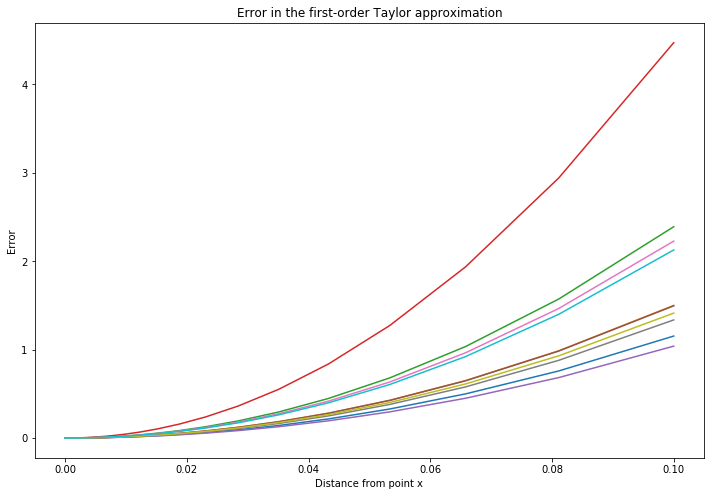

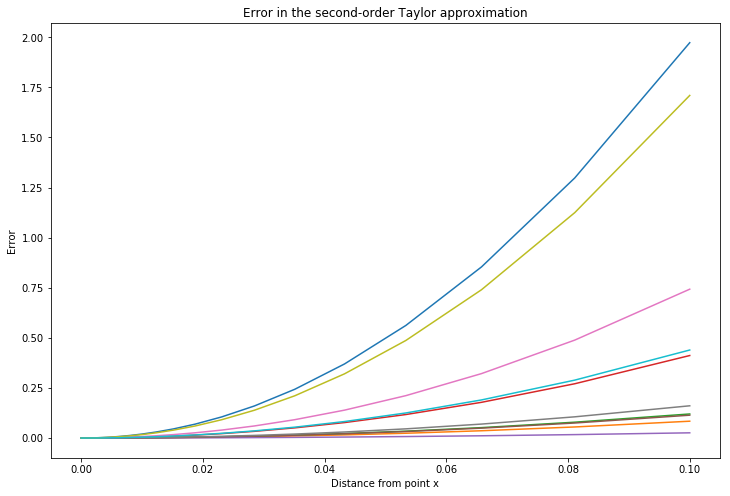

In [5]:
# Test the gradient check with some random test data

m = 20
n = 20

#np.random.seed(1)
A = np.random.randn(m,n)
b = np.random.randn(m)
x = np.random.randn(n)

f = lambda x, flg : evaluate_regularized_lsq(A,x,b,beta = 0, flag = flg) 

check_derivative(f, x, 'g')
check_derivative(f, x, 'h')

## 2.

>The regularized least squares problem allows for an analytical solution. Since the Hessian is positive definite, any stationary point is optimal. Since this is a quadratic, convex problem, a stationary point x* will satisfy the optimality condition g(x*) = 0, where g(x) is the gradient of the objective function. Use this equality to derive a system of the form Lx = y. To construct a (synthetic) test problem, use the matrix $A = \tilde A^\top \tilde A + 1e−3 diag(1, 1, 1)$, where
>$$ \tilde A = \begin{bmatrix}1 &1 &1 \\ 1& 2& 3 \end{bmatrix} \quad \text{and} \quad x^* = \begin{bmatrix} 1\\2\\3 \end{bmatrix}
$$
>represents the true solution to our problem. We construct $b$ to be (approximately) in the column space of $A$. That is, $b = Ax^* + dx$, where $dx$ represents noise (i.e., a random perturbation). Use deltax = 0.01*randn(3,1) to compute $dx$. Solve the linear system $Ax = b$ and $Lx = y$ by using Matlab’s backslash command, i.e., e.g., x = A \ b. Compare the solutions x_sol of $Lx = y$ (for b = 1 and B = diag(1, 1, 1)) and the solution for $Ax = b$ to the true solution x*. That is, print the values of x_sol and the relative error $\|x^* − xsol\|_2 / \|x^*\|_2$. Add comments to your script that describe what you observe. Submit your scripts and functions as described in the general instructions for the homework.

We derive the solution for g(x) = 0, in the form of $Lx=y$:

$$\nabla f(x) = A^\top A x - A^\top b + \beta B^\top B x = 0 $$
$$(A^\top A  + \beta B^\top B) x = A^\top b $$

In [4]:
A_tilde = np.array([[1,1,1],[1,2,3]])
A = A_tilde.T @ A_tilde + 0.01 * np.diag([1,1,1])
x_star = np.array([1,2,3])
deltax = 0.01 * np.random.randn(3)
b = A @ x_star + deltax
beta = 1
B = np.diag([1,1,1])

print(f"The condition number of A is {np.linalg.cond(A)}")

x = np.linalg.solve(A, b)
rel_error_x = np.linalg.norm(x_star - x) / np.linalg.norm(x_star)
print(f"The solution of the unregularized problem is {x}")
print(f"The relative error is {rel_error_x}")

L = A.T @ A + beta * B.T @ B
y = A.T @ b
print(f"The condition number of L is {np.linalg.cond(L)}")

x_sol = np.linalg.solve(L, y)
rel_error_x_sol = np.linalg.norm(x_star - x_sol) / np.linalg.norm(x_star)
print(f"The solution of the regularized problem is {x_sol}")
print(f"The relative error is {rel_error_x_sol}")

The condition number of A is 1664.941029805038
The solution of the unregularized problem is [0.08822475 3.9369517  2.00887777]
The relative error is 0.6305008944235809
The condition number of L is 278.1750457682291
The solution of the regularized problem is [1.18347739 2.03356972 2.88308443]
The relative error is 0.058833984831971074


We note that $\tilde A^\top \tilde A$ is singular, and therefore presents no unique solution.  We further observe that, as constructed, $A$ has a very high condition number, so we expect that the problem will not present a good solution.  This is indeed the case. 

The condition number for the regularized problem is better, and the solution is closer to $x^*$, but it is still not great. 